In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from tabulate import tabulate
from src import camvid
from src import evaluate
from src import predict
from src import predict_video
from src import segnet
from src.callbacks import PlotMetrics
from src.utils import history_to_results
%matplotlib inline
plt.style.use('dark_background')

Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
weights_file = 'models/SegNet-CamVid11.h5'

In [3]:
# the batch size for training
batch_size = 8
# the size to crop images to
crop_size = (352, 480)

# Training

In [4]:
camvid11 = camvid.CamVid(
    mapping=camvid.load_mapping(), 
    target_size=(360, 480), 
    crop_size=crop_size, 
    batch_size=batch_size, 
    ignored_labels=['Void'],
)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


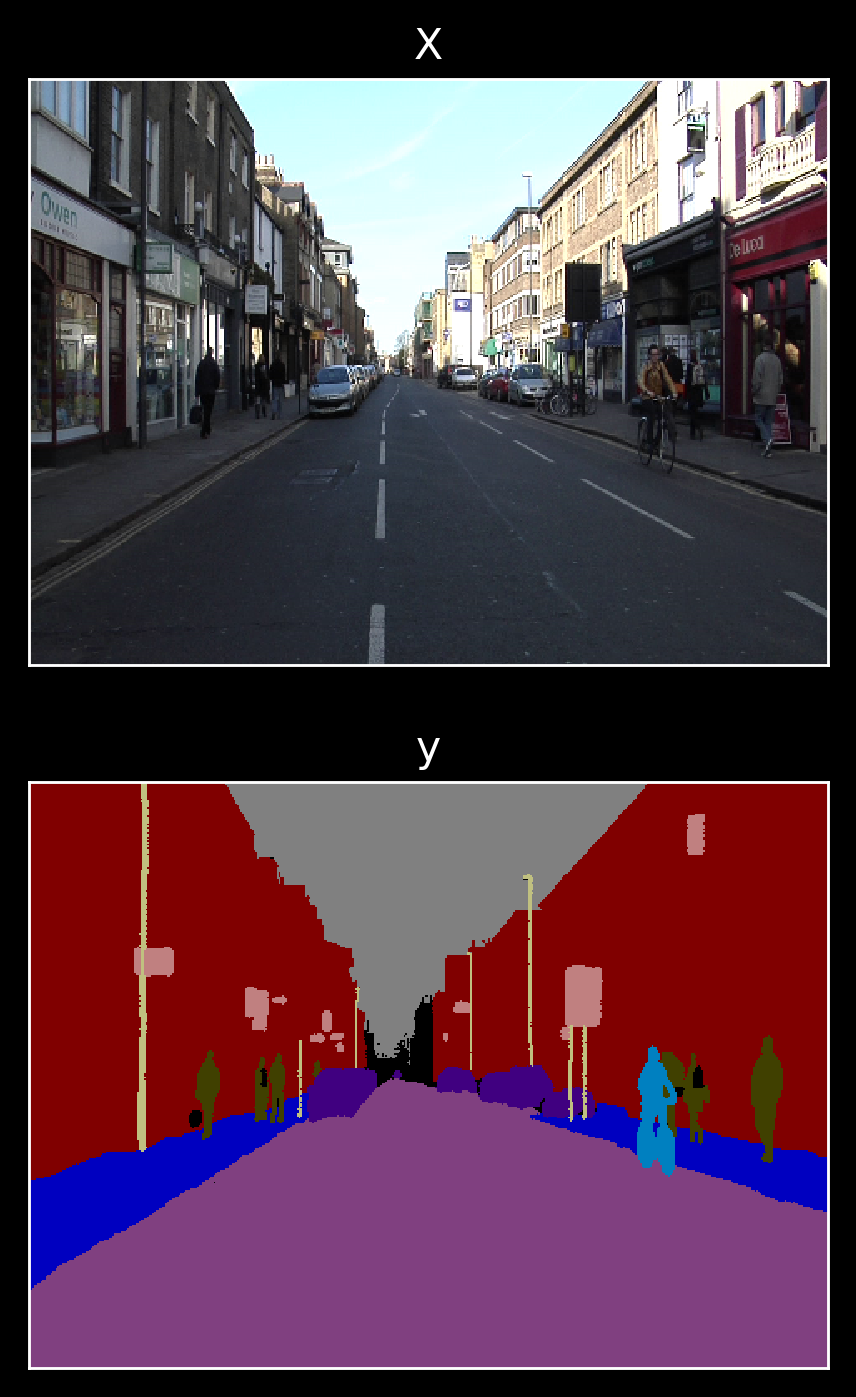

In [5]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0], order=['X', 'y'])

In [6]:
# build the model for the image shape and number of labels
model = segnet.segnet((*crop_size, 3), camvid11.n, camvid11.class_weights)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SegNet_input (InputLayer)    (None, 352, 480, 3)       0         
_________________________________________________________________
pixel_norm (Lambda)          (None, 352, 480, 3)       0         
_________________________________________________________________
local_contrast_normalization (None, 352, 480, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 352, 480, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 352, 480, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 352, 480, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 352, 480, 64)      36928     
__________

In [7]:
# # create the callbacks for the training procedure
# callbacks = [
#     EarlyStopping(monitor='loss', patience=10),
#     LearningRateScheduler(lambda _, lr: 0.95 * lr),
#     ModelCheckpoint(weights_file, 
#         monitor='val_categorical_accuracy', 
#         save_best_only=True, 
#         save_weights_only=True, 
#         mode='max',
#     ),
#     PlotMetrics(),
# ]

In [8]:
# # fit the model with the data. divide the steps per epoch by the 
# # batch size (which is 3 in this case)
# history = model.fit_generator(generators['train'],
#     epochs=100,
#     steps_per_epoch=int(367 / batch_size),
#     validation_data=generators['val'],
#     validation_steps=101,
#     callbacks=callbacks,
#     verbose=0
# )

In [9]:
# history_to_results(history)

## Load Best Model

In [10]:
model.load_weights(weights_file)

# Test Metrics

In [11]:
metrics = evaluate.evaluate(model, generators['test'], 233,
    mask=camvid11.class_mask, 
    label_map=camvid11.label_to_discrete_map
)
metrics

100%|██████████| 233/233 [01:01<00:00,  3.79step/s]


Test
Accuracy                 0.889125
Mean Per Class Accuracy  0.681254
Mean I/U                 0.565375
Bicyclist                0.404283
Building                 0.741864
Car                      0.653990
Column_Pole              0.228868
Fence                    0.353242
Pedestrian               0.414915
Road                     0.899917
Sidewalk                 0.761276
SignSymbol               0.181454
Sky                      0.886353
VegetationMisc           0.692969

In [12]:
print(tabulate(metrics, tablefmt='pipe', headers=('Metric', 'Value')))

| Metric                  |    Value |
|:------------------------|---------:|
| Accuracy                | 0.889125 |
| Mean Per Class Accuracy | 0.681254 |
| Mean I/U                | 0.565375 |
| Bicyclist               | 0.404283 |
| Building                | 0.741864 |
| Car                     | 0.65399  |
| Column_Pole             | 0.228868 |
| Fence                   | 0.353242 |
| Pedestrian              | 0.414915 |
| Road                    | 0.899917 |
| Sidewalk                | 0.761276 |
| SignSymbol              | 0.181454 |
| Sky                     | 0.886353 |
| VegetationMisc          | 0.692969 |


# Qualitative Results

### Train

In [13]:
X, y, p = predict.predict(model, generators['train'], camvid11)

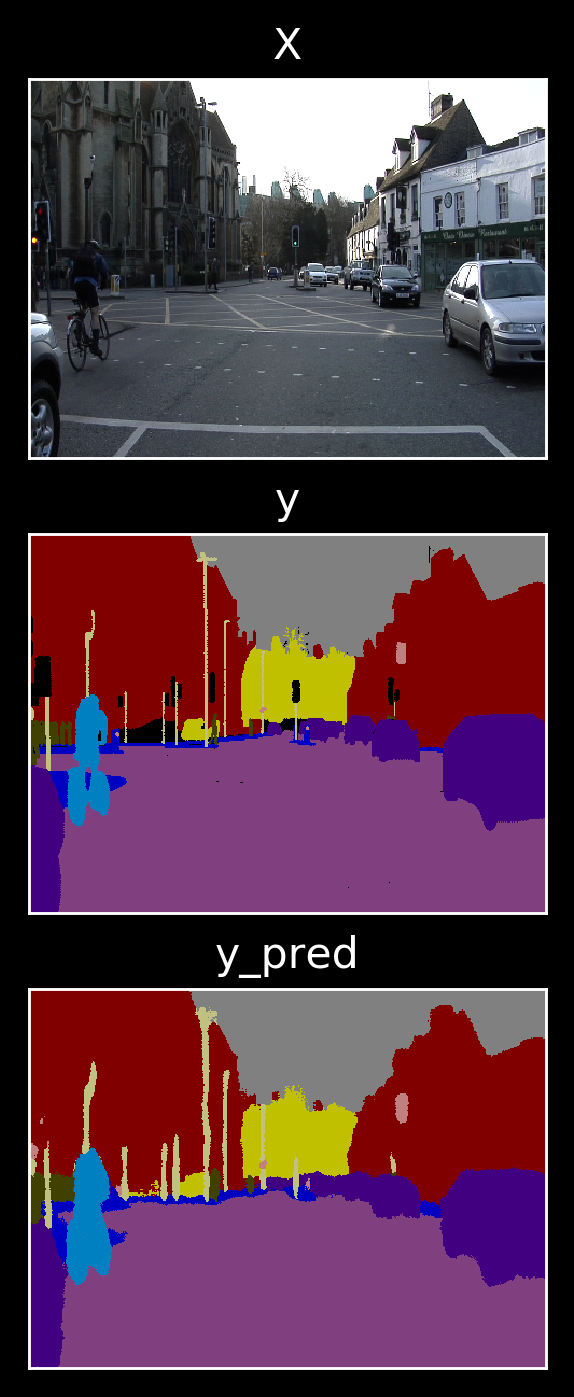

In [14]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

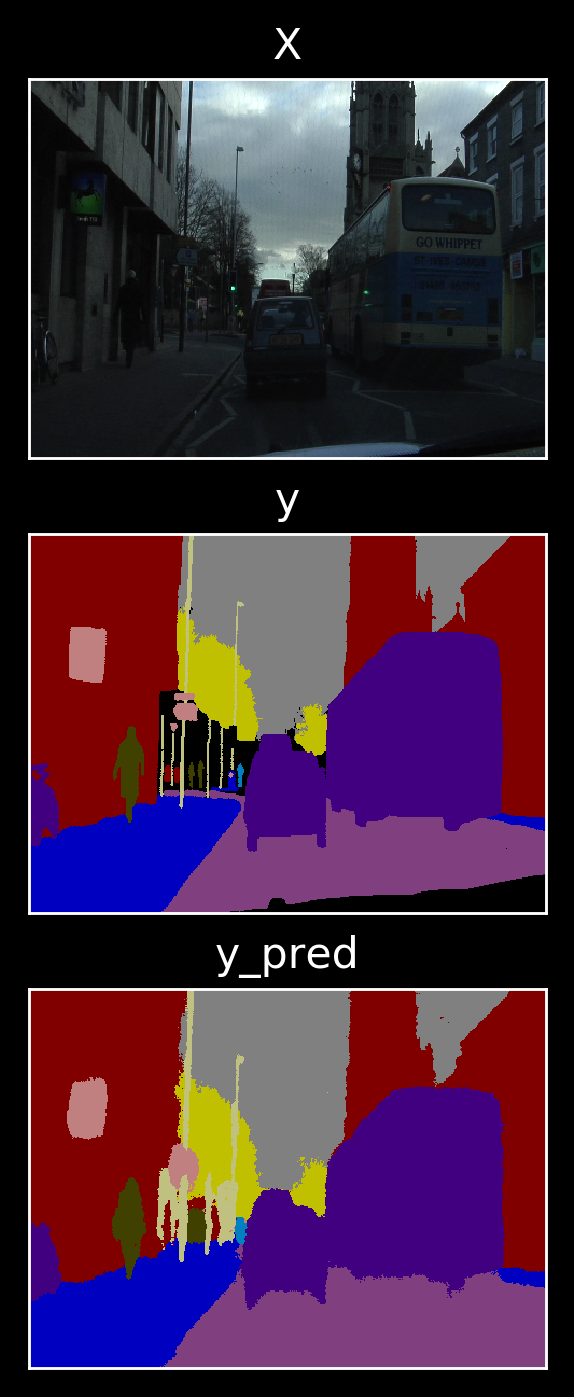

In [15]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1], order=['X', 'y', 'y_pred'])

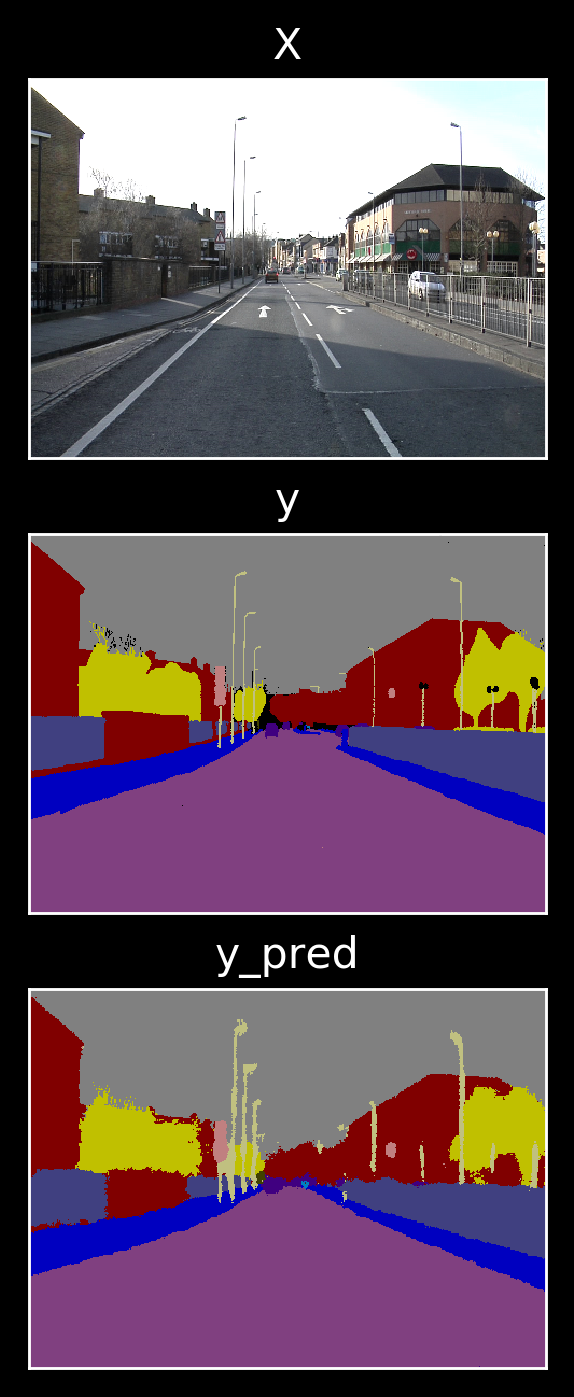

In [16]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2], order=['X', 'y', 'y_pred'])

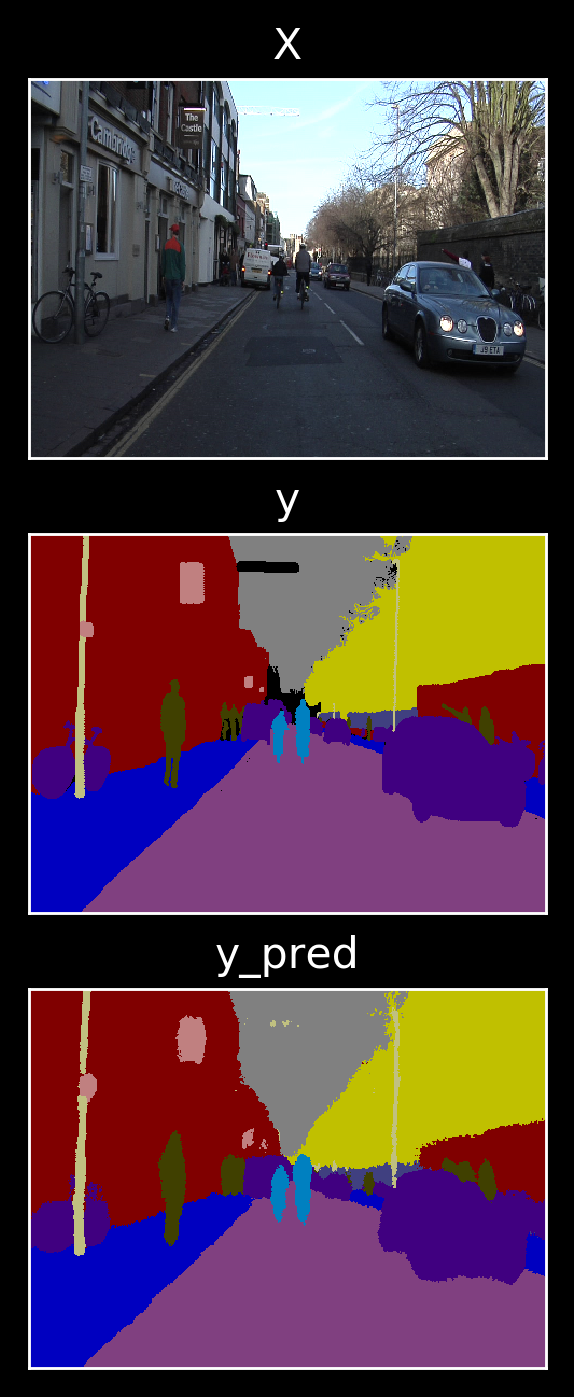

In [17]:
camvid.plot(X=X[3], y=y[3], y_pred=p[3], order=['X', 'y', 'y_pred'])

### Validation

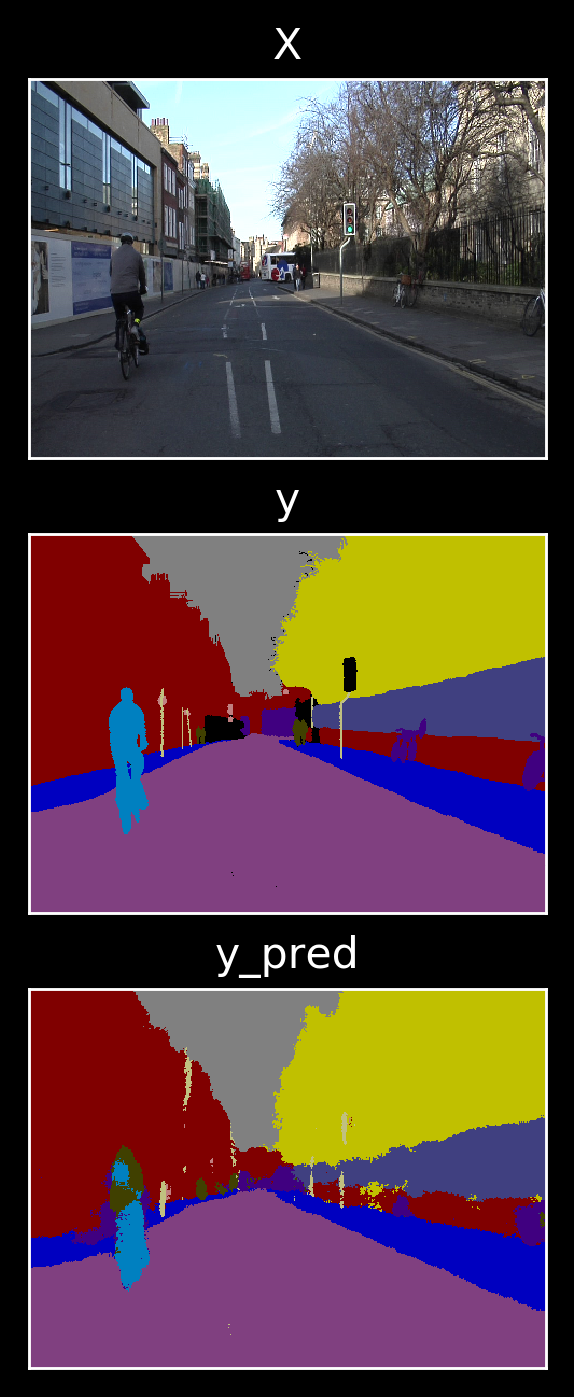

In [18]:
X, y, p = predict.predict(model, generators['val'], camvid11)
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

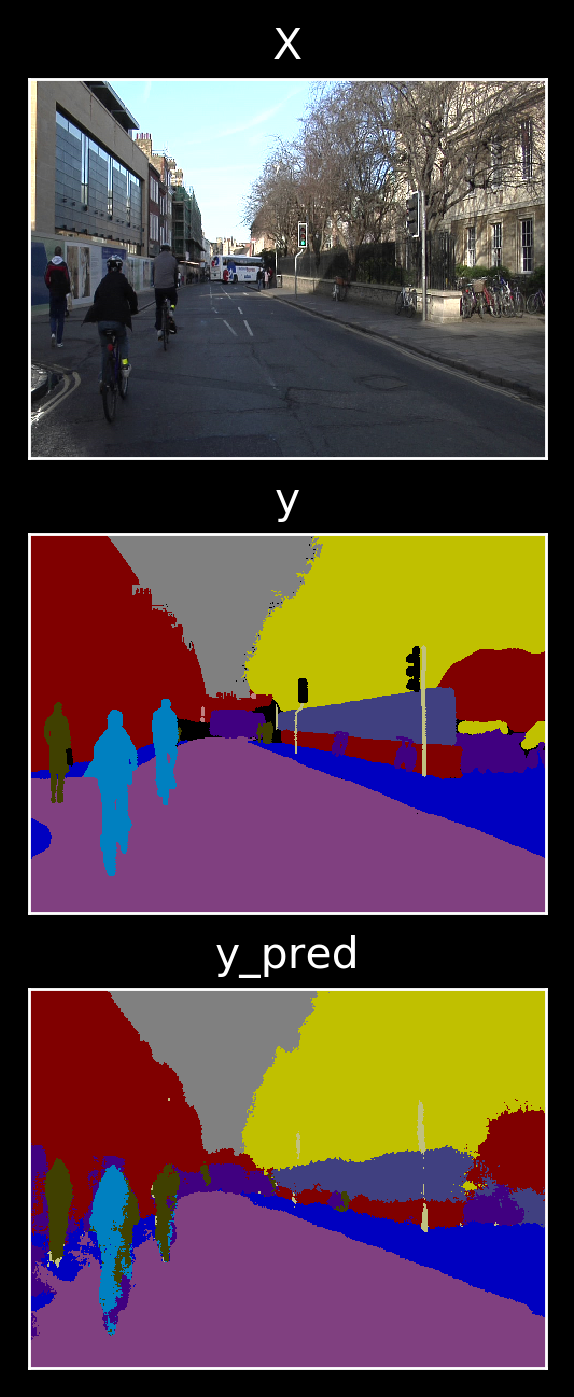

In [19]:
X, y, p = predict.predict(model, generators['val'], camvid11)
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

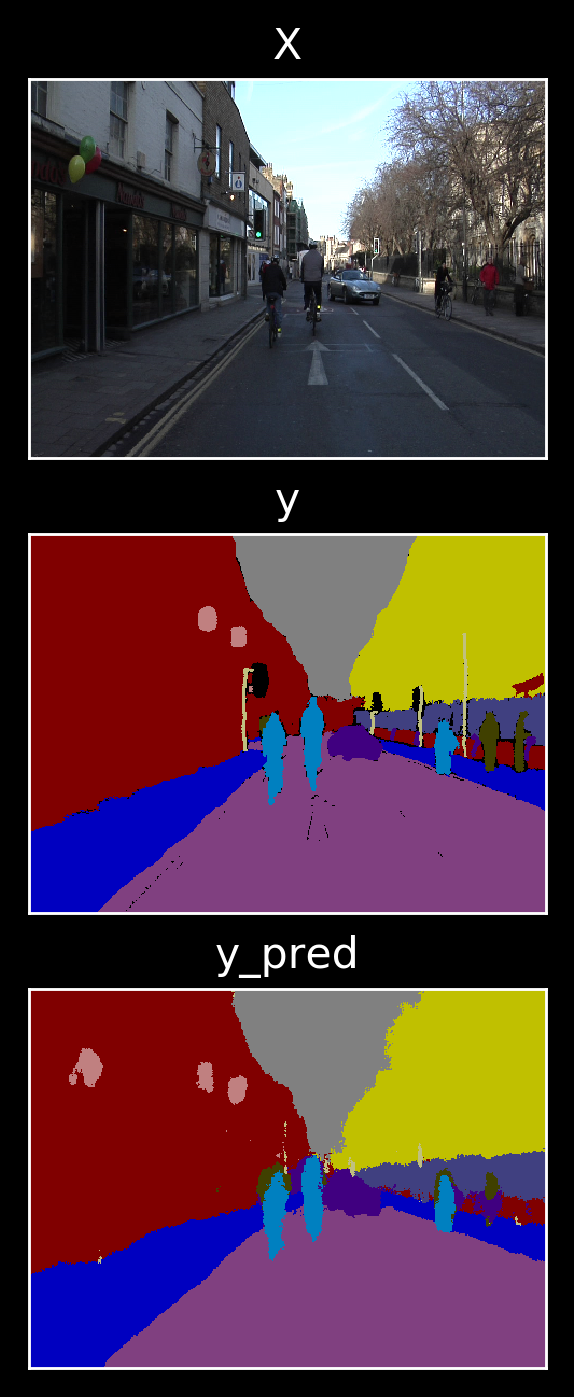

In [20]:
X, y, p = predict.predict(model, generators['val'], camvid11)
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

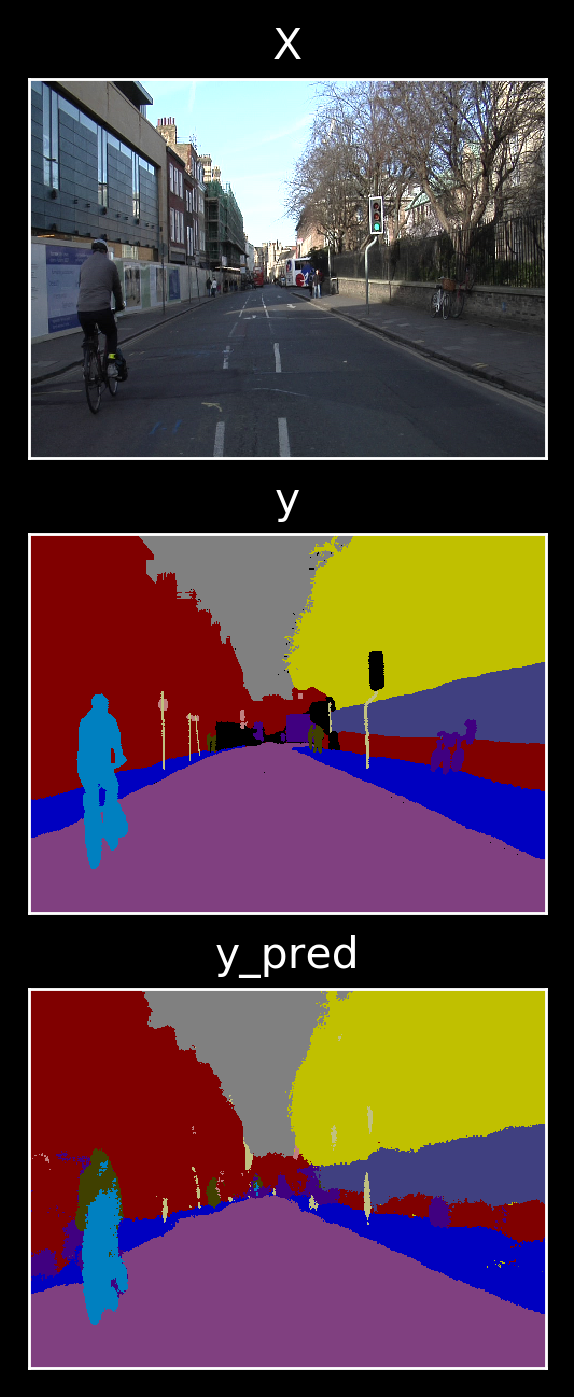

In [21]:
X, y, p = predict.predict(model, generators['val'], camvid11)
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

### Test

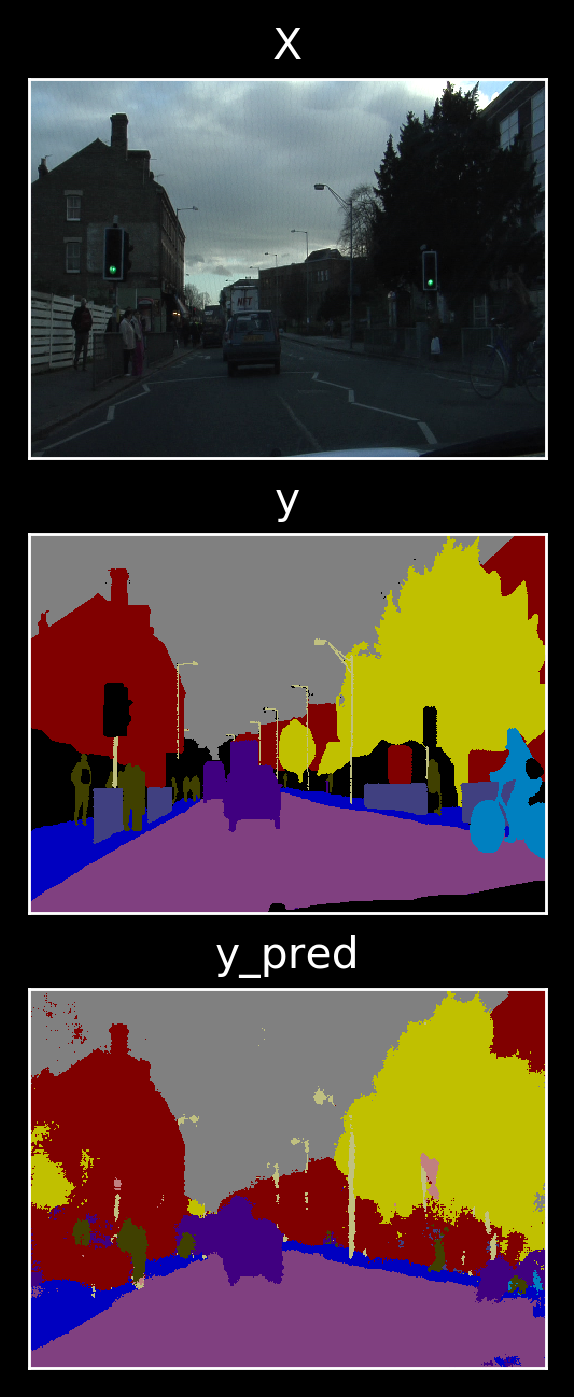

In [22]:
X, y, p = predict.predict(model, generators['test'], camvid11)
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
plt.savefig('img/segnet/0.png')

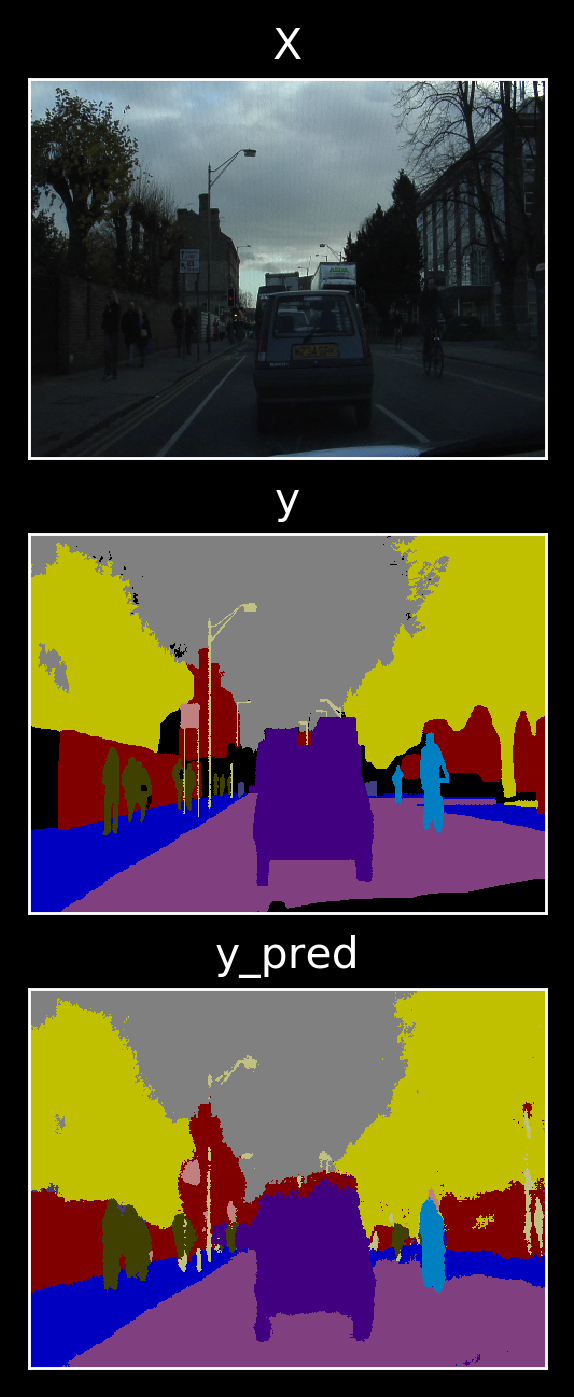

In [23]:
X, y, p = predict.predict(model, generators['test'], camvid11)
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
plt.savefig('img/segnet/1.png')

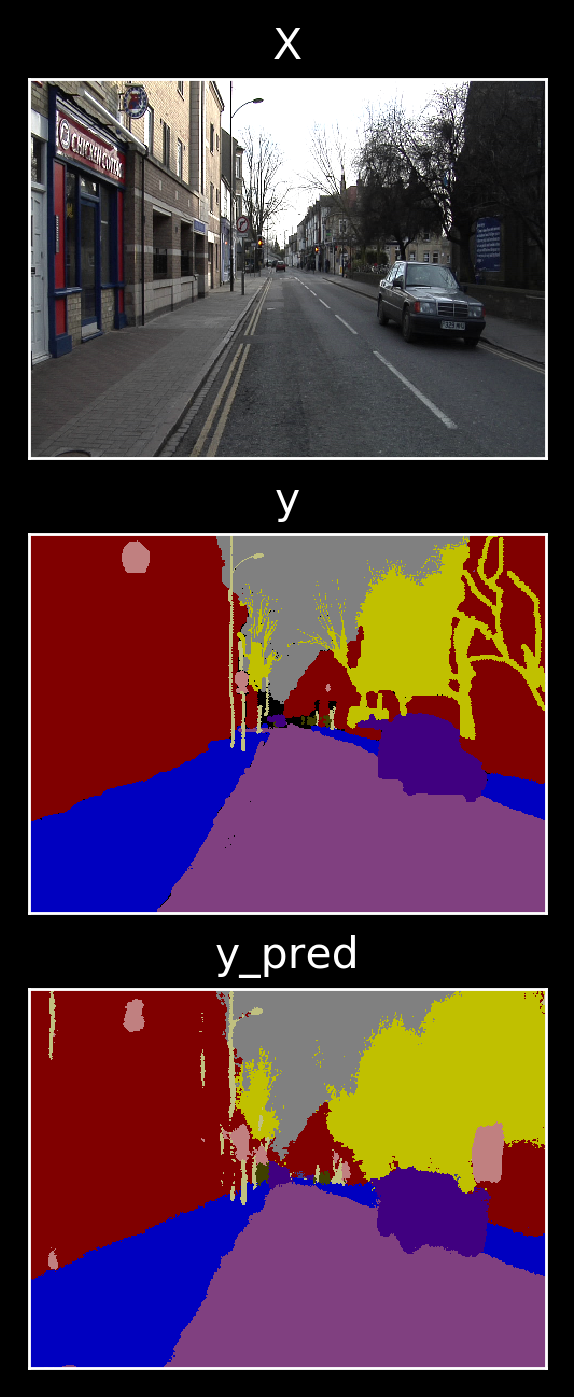

In [24]:
X, y, p = predict.predict(model, generators['test'], camvid11)
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
plt.savefig('img/segnet/2.png')

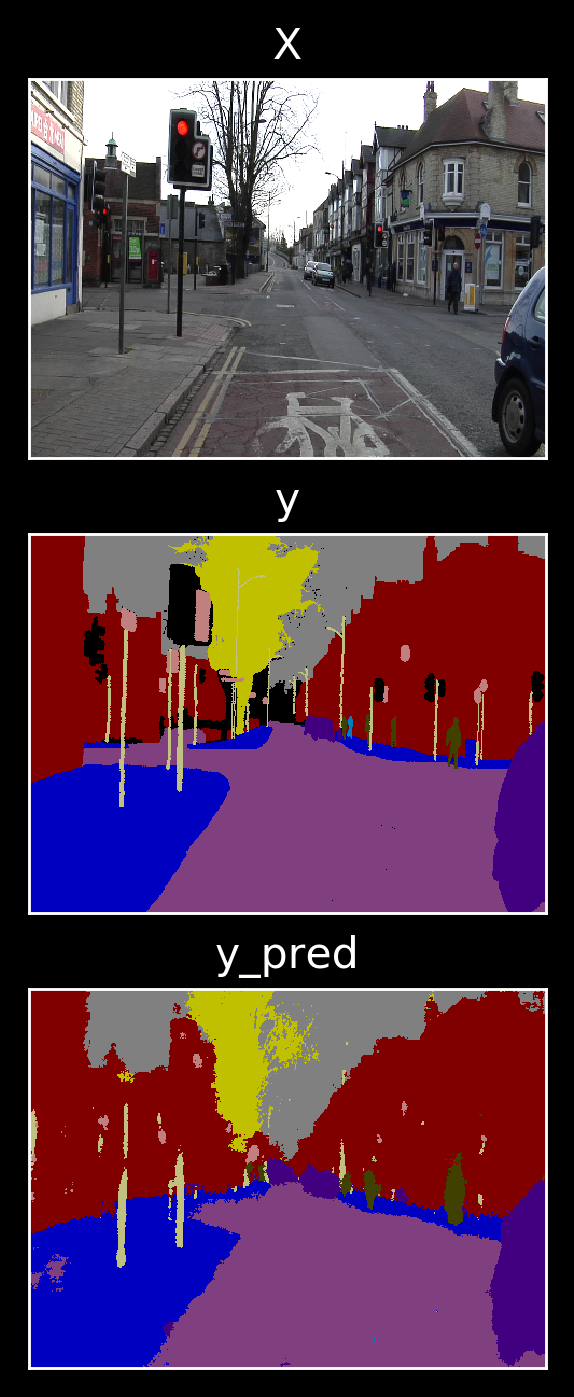

In [25]:
X, y, p = predict.predict(model, generators['test'], camvid11)
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
plt.savefig('img/segnet/3.png')

# Video

In [26]:
video_file = '0005VD.mp4'
video_path = camvid.videos.abs_path(video_file)
out_path = 'img/segnet/{}'.format(video_file)

In [27]:
predict_video.predict_video(video_path, out_path, camvid11, model, predict.predict)

100%|██████████| 6600/6600 [18:52<00:00,  5.83it/s]
